In [15]:
import pandas as pd
import numpy as np
import pandas_profiling as pdp
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

Load Data

In [3]:
INPUT_DIR = './m5-forecasting-accuracy'
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')

データ確認

In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


convert data

In [8]:
sales_train_val.index=sales_train_val.id
test=sales_train_val.iloc[:,6:].stack()

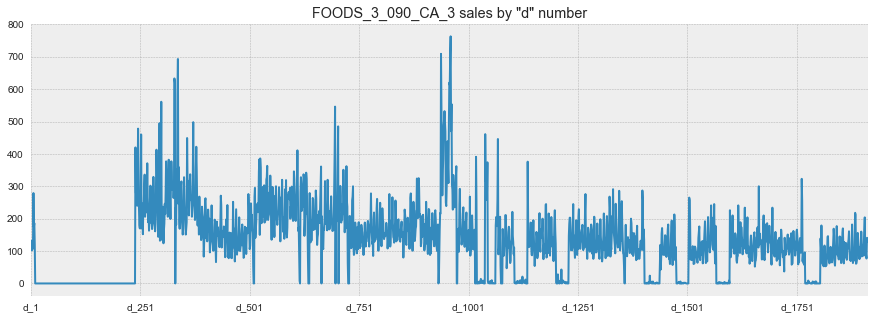

In [16]:
d_cols = [c for c in sales_train_val.columns if 'd_' in c] # sales data columns
# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
sales_train_val.loc[sales_train_val['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

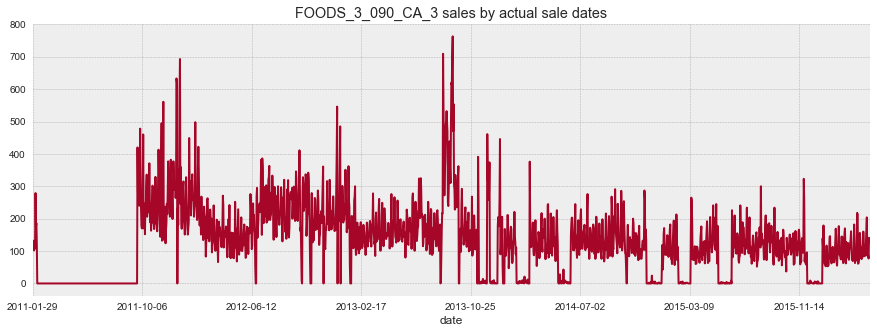

In [22]:
# Merge calendarendar on our items' data
example = sales_train_val.loc[sales_train_val['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(calendar, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3_validation'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Select more top selling examples
example2 = sales_train_val.loc[sales_train_val['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(calendar, how='left', validate='1:1')

example3 = sales_train_val.loc[sales_train_val['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(calendar, how='left', validate='1:1')


###週次 月次　年次で可視化

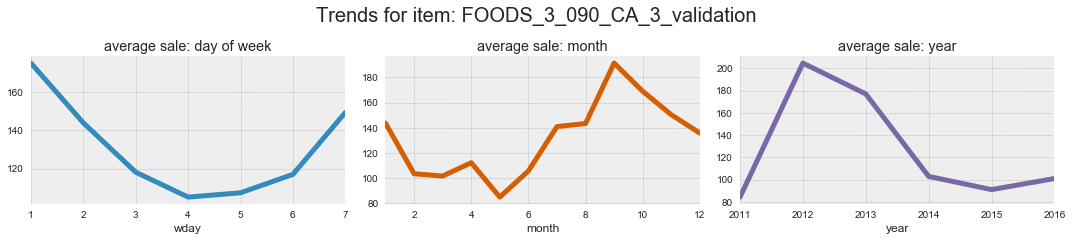

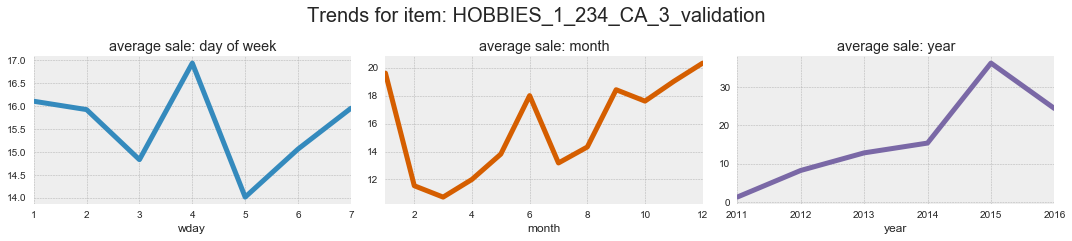

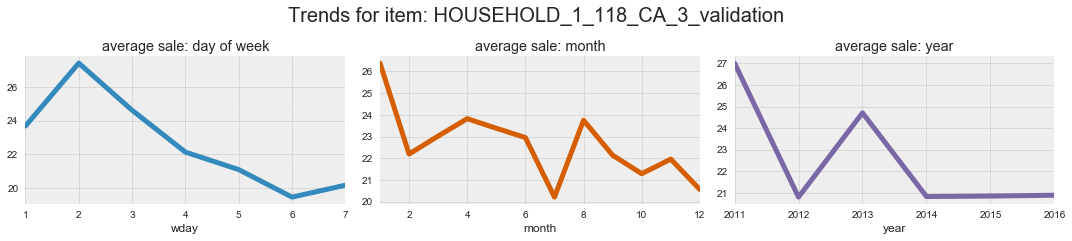

In [24]:
examples = ['FOODS_3_090_CA_3_validation','HOBBIES_1_234_CA_3_validation','HOUSEHOLD_1_118_CA_3_validation']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

サンプルで可視化

In [28]:
twenty_examples = sales_train_val.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

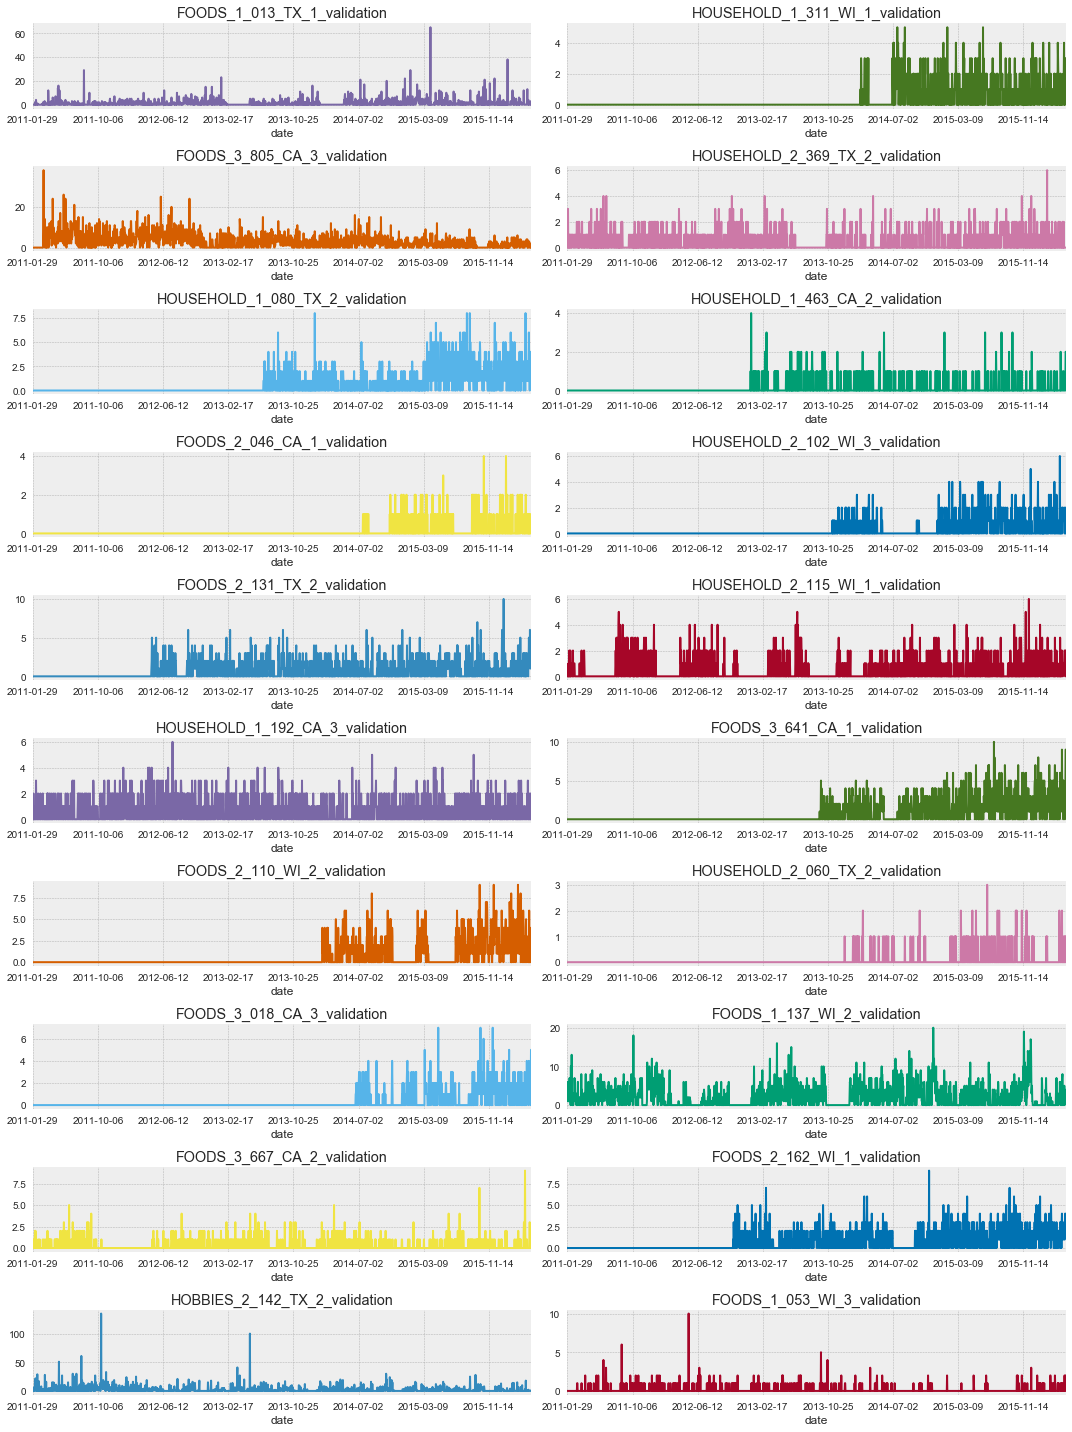

In [29]:

fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

In [31]:
sales_train_val['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

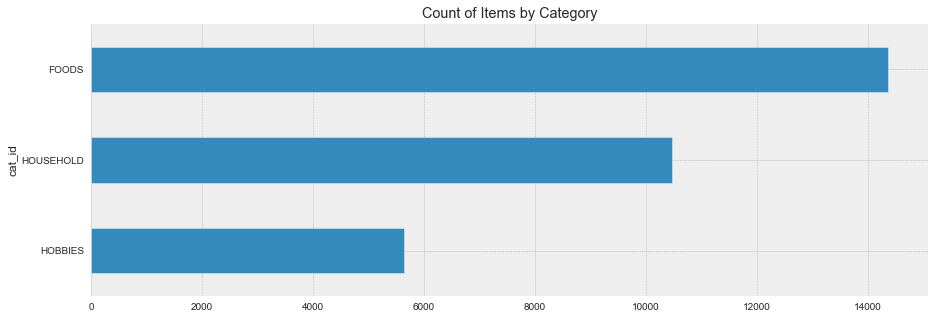

In [32]:
sales_train_val.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

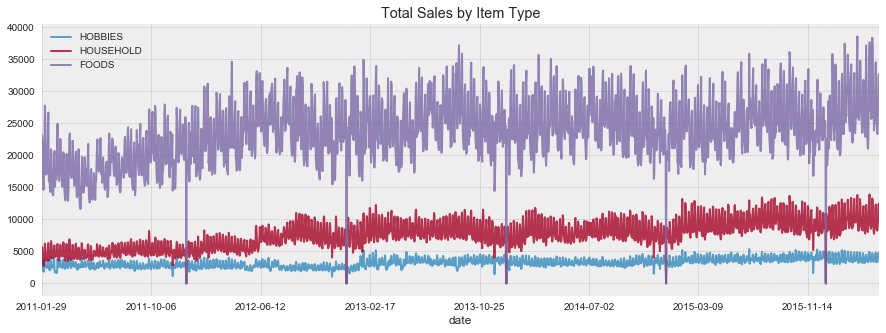

In [34]:
past_sales = sales_train_val.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in sales_train_val['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(sales_train_val['cat_id'].unique())
plt.show()